In [1]:
import cv2
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


In [2]:
# ============================================================
# Prepair Dataset
# ============================================================

def Preprocess_and_save_images(INPUT_DIR, OUTPUT_DIR, TARGET_SIZE):
    # Ustvari izhodni direktorij, če še ne obstaja
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Pridobi vse .jpg slike
    image_paths = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR)
                   if f.lower().endswith(('.jpg', '.jpeg'))]

    print(f"Najdenih {len(image_paths)} slik za obdelavo...")

    for path in tqdm(image_paths, desc="Obdelujem slike"):
        # Preberi sliko
        img = cv2.imread(path)
        if img is None:
            print(f"❌ Napaka pri branju slike: {path}")
            continue

        # Pretvori v sivinsko
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Spremeni velikost (320x240)
        resized = cv2.resize(gray, TARGET_SIZE)

        # Ustvari enako ime datoteke v izhodni mapi
        filename = os.path.basename(path)
        output_path = os.path.join(OUTPUT_DIR, filename)

        # Shrani obdelano sliko
        cv2.imwrite(output_path, resized)

    print("✅ Vse slike so uspešno predobdelane in shranjene v:")
    print(f"   {OUTPUT_DIR}")


INPUT_DIR = "datasets/val2017"
PREPROCESSED_DIR = "datasets/val2017_preprocessed"

TARGET_SIZE = (320, 240)
# Preprocess_and_save_images(INPUT_DIR, OUTPUT_DIR, TARGET_SIZE)


In [3]:
# ============================================================
# HELPER FUNKCIJE ZA GENERIRANJE PAROV
# ============================================================

def sample_window(img_shape, window_size=64, margin=16):
    h, w = img_shape[:2]
    x = random.randint(margin, w - margin - window_size)
    y = random.randint(margin, h - margin - window_size)
    return x, y


def get_corners(x, y, window_size=64):
    return np.array([
        [x, y],
        [x + window_size, y],
        [x + window_size, y + window_size],
        [x, y + window_size]
    ], dtype=np.float32)


def perturb_corners(corners, disp_range=(-16, 16)):
    min_disp, max_disp = disp_range
    disp = np.random.randint(min_disp, max_disp + 1, size=corners.shape).astype(np.float32)
    return corners + disp, disp


def generate_pair(img, window_size=64, margin=16, disp_range=(-16, 16)):
    h, w = img.shape[:2]

    x, y = sample_window((h, w), window_size, margin)

    src_corners = get_corners(x, y, window_size)
    dst_corners, disp = perturb_corners(src_corners, disp_range)
    # print("src_corners: ", src_corners)
    # print("dst_corners: ", dst_corners)
    # print("disp: ", disp)

    # Homografija H (src -> dst) in njen inverz
    H = cv2.getPerspectiveTransform(src_corners, dst_corners)
    H_inv = np.linalg.inv(H)

    # Warp celotne slike z H^-1
    warped = cv2.warpPerspective(img, H_inv, (w, h), flags=cv2.INTER_LINEAR)

    # Izreži patche
    orig_patch = img[y:y + window_size, x:x + window_size]
    warped_patch = warped[y:y + window_size, x:x + window_size]

    # Stack v 2 kanala in normaliziraj
    pair = np.stack([orig_patch, warped_patch], axis=-1).astype(np.float32) / 255.0

    # Ground truth: pomiki kotičkov
    offsets = (dst_corners - src_corners).astype(np.float32)
    # print("offsets: ", offsets)

    return pair, offsets, src_corners, warped


In [4]:
# ============================================================
# TEST GENERIRANJA PARA
# ============================================================

def visualize_generate_pair(image_dir):
    # Nalož naključno sliko
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    img_path = random.choice(image_paths)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    h, w = img.shape[:2]
    window_size = 64
    margin = 16
    disp_range = (-16, 16)

    # Sample window
    x, y = sample_window((h, w), window_size, margin)

    # Get corners
    src_corners = get_corners(x, y, window_size)
    dst_corners = perturb_corners(src_corners, disp_range)

    # Compute homography
    H = cv2.getPerspectiveTransform(src_corners, dst_corners)
    H_inv = np.linalg.inv(H)

    # Warp image
    warped = cv2.warpPerspective(img, H_inv, (w, h), flags=cv2.INTER_LINEAR)

    # Extract patches
    orig_patch = img[y:y + window_size, x:x + window_size]
    warped_patch = warped[y:y + window_size, x:x + window_size]

    # Calculate offsets
    offsets = dst_corners - src_corners

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Original image with source corners
    ax = axes[0, 0]
    ax.imshow(img, cmap='gray')
    for i, (cx, cy) in enumerate(src_corners):
        ax.plot(cx, cy, 'go', markersize=10)
        ax.text(cx, cy - 5, f'{i}', color='green', fontsize=12, ha='center')
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    ax.set_title('Original Image + Source Corners (green)')
    ax.axis('off')

    # 2. Original image with destination corners
    ax = axes[0, 1]
    ax.imshow(img, cmap='gray')
    for i, (cx, cy) in enumerate(dst_corners):
        ax.plot(cx, cy, 'ro', markersize=10)
        ax.text(cx, cy - 5, f'{i}', color='red', fontsize=12, ha='center')
    # Draw lines showing displacement
    for i in range(4):
        ax.arrow(src_corners[i, 0], src_corners[i, 1],
                 offsets[i, 0], offsets[i, 1],
                 head_width=3, head_length=3, fc='yellow', ec='yellow', alpha=0.7)
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='green', linewidth=2, linestyle='--')
    ax.add_patch(rect)
    ax.set_title(f'Perturbed Corners (red)\nAvg offset: {np.abs(offsets).mean():.1f}px')
    ax.axis('off')

    # 3. Warped image with H^-1
    ax = axes[0, 2]
    ax.imshow(warped, cmap='gray')
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    ax.set_title('Warped Image (H⁻¹ applied)')
    ax.axis('off')

    # 4. Original patch
    ax = axes[1, 0]
    ax.imshow(orig_patch, cmap='gray')
    ax.set_title('Original Patch (64×64)')
    ax.axis('off')

    # 5. Warped patch
    ax = axes[1, 1]
    ax.imshow(warped_patch, cmap='gray')
    ax.set_title('Warped Patch (64×64)')
    ax.axis('off')

    # Hide the 6th subplot
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print offsets
    print("\nCorner offsets (Δx, Δy):")
    for i, (dx, dy) in enumerate(offsets):
        print(f"  Corner {i}: ({dx:+.1f}, {dy:+.1f}) px")


PREPROCESSED_DIR = "datasets/val2017_preprocessed"
# Run visualization
# if os.path.exists(PREPROCESSED_DIR):
#     visualize_generate_pair(PREPROCESSED_DIR)

In [5]:
def visualize_offset_sign(image_dir, window_size=64, margin=16, disp_range=(-16, 16)):
    # Pick random image
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_paths:
        print("❌ No images found in", image_dir)
        return

    img_path = random.choice(image_paths)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Could not read image:", img_path)
        return

    # Generate pair using your pipeline
    pair, offsets, src_corners, warped_true = generate_pair(
        img, window_size=window_size, margin=margin, disp_range=disp_range
    )
    dst_corners = src_corners + offsets

    # Reconstruct warps using both offset signs
    H_plus = cv2.getPerspectiveTransform(src_corners, dst_corners)
    H_minus = cv2.getPerspectiveTransform(src_corners, src_corners - offsets)

    warped_plus = cv2.warpPerspective(img, H_plus, (img.shape[1], img.shape[0]))
    warped_minus = cv2.warpPerspective(img, H_minus, (img.shape[1], img.shape[0]))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    # 1️⃣ True warped image
    axes[0].imshow(warped_true, cmap='gray')
    axes[0].add_patch(plt.Polygon(src_corners, fill=False, edgecolor='green', lw=2, label='src'))
    axes[0].add_patch(plt.Polygon(dst_corners, fill=False, edgecolor='blue', lw=2, label='dst (GT)'))
    axes[0].set_title("True warped image (from generate_pair)")
    axes[0].legend()
    axes[0].axis('off')

    # 2️⃣ Reconstructed with +offsets
    axes[1].imshow(warped_plus, cmap='gray')
    axes[1].add_patch(plt.Polygon(src_corners, fill=False, edgecolor='green', lw=2))
    axes[1].add_patch(plt.Polygon(dst_corners, fill=False, edgecolor='red', lw=2))
    axes[1].set_title("Reconstructed warp (+offsets)")
    axes[1].axis('off')

    # 3️⃣ Reconstructed with -offsets
    axes[2].imshow(warped_minus, cmap='gray')
    axes[2].add_patch(plt.Polygon(src_corners, fill=False, edgecolor='green', lw=2))
    axes[2].add_patch(plt.Polygon(dst_corners, fill=False, edgecolor='red', lw=2))
    axes[2].set_title("Reconstructed warp (-offsets)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Numeric comparison for confirmation
    diff_plus = np.mean(np.abs(warped_true.astype(np.float32) - warped_plus.astype(np.float32)))
    diff_minus = np.mean(np.abs(warped_true.astype(np.float32) - warped_minus.astype(np.float32)))

    print(f"Mean pixel difference (true vs +offsets): {diff_plus:.2f}")
    print(f"Mean pixel difference (true vs -offsets): {diff_minus:.2f}")

    if diff_minus < diff_plus:
        print("⚠️ Offsets likely need to be NEGATED during training.")
    else:
        print("✅ Offsets appear to have the correct sign.")

# visualize_offset_sign(PREPROCESSED_DIR)


In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None, stride=1,
                 dropout_rate=0.1):
        super(ResNetBlock, self).__init__()
        out_channels = out_channels or in_channels  # če ni določeno, ohrani enako št. kanalov

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.relu = nn.ReLU(inplace=True)

        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.dropout(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.dropout(out)
        out += residual

        out = self.relu(out)
        return out


In [7]:
class ResNetBody(nn.Module):
    def __init__(self, in_channels=2, dropout_rate=0.1):
        super(ResNetBody, self).__init__()

        # ----- 1. stopnja -----
        self.layer1 = nn.Sequential(
            ResNetBlock(in_channels, 64, dropout_rate=dropout_rate),
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64 -> 32x32
        )

        # ----- 2. stopnja -----
        self.layer2 = nn.Sequential(
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16
        )

        # ----- 3. stopnja -----
        self.layer3 = nn.Sequential(
            ResNetBlock(64, 128, dropout_rate=dropout_rate),
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16 -> 8x8
        )

        # ----- 4. stopnja -----
        self.layer4 = nn.Sequential(
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            # zadnji max pool ni potreben, ohranimo 8x8
        )

        # ----- Polno povezan sloj -----
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 8 * 8, 512)

    def forward(self, x):  # Nx2x64x64
        x = self.layer1(x)  # Nx64x32x32
        x = self.layer2(x)  # Nx64x16x16
        x = self.layer3(x)  # Nx128x8x8
        x = self.layer4(x)  # Nx128x8x8
        x = self.flatten(x)  # Nx8192
        x = self.fc(x)  # Nx512
        return x


In [8]:
class RegressionHead(nn.Module):
    def __init__(self, in_features=512, out_features=8):
        super(RegressionHead, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):  # Nx512
        return self.fc(x)  # Nx8

In [9]:
class ClassificationHead(nn.Module):
    def __init__(self, in_features=512, num_classes=21, class_dim=8):
        super(ClassificationHead, self).__init__()
        self.num_classes = num_classes
        self.class_dim = class_dim
        self.fc = nn.Linear(in_features, class_dim * num_classes)
        # self.softmax = nn.Softmax(dim=2)

    def forward(self, x):  # Nx512
        x = self.fc(x)  # Nx168
        x = x.view(-1, self.num_classes, self.class_dim)  # Nx21x8
        # x = self.softmax(x)  # Nx8x21
        return x

In [10]:
class HomographyRegressor(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(HomographyRegressor, self).__init__()
        self.body = ResNetBody(in_channels=2, dropout_rate=dropout_rate)
        self.head = RegressionHead(in_features=512, out_features=8)

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

In [11]:
class HomographyClassifier(nn.Module):
    def __init__(self, num_classes=21, class_dim=8, dropout_rate=0.1):
        super(HomographyClassifier, self).__init__()
        self.body = ResNetBody(in_channels=2, dropout_rate=dropout_rate)
        self.head = ClassificationHead(in_features=512,
                                       num_classes=num_classes,
                                       class_dim=class_dim)

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

In [12]:
import os
import re


def extract_epoch(filename):
    match = re.search(r"epoch_(\d+)", filename)
    return int(match.group(1)) if match else -1


In [13]:
class HomographyPairDataset(Dataset):
    def __init__(self, images, samples_per_epoch, window_size=64, margin=16, disp_range=(-16, 16)):
        self.images = images if isinstance(images, list) else [images]
        self.samples_per_epoch = samples_per_epoch
        self.window_size = window_size
        self.margin = margin
        self.disp_range = disp_range

    def __len__(self):
        return self.samples_per_epoch

    def __getitem__(self, idx):
        # Generate a random pair from a random image
        img = random.choice(self.images)
        pair, offsets, _, _ = generate_pair(
            img,
            window_size=self.window_size,
            margin=self.margin,
            disp_range=self.disp_range
        )

        # Convert to tensors
        pair = torch.from_numpy(pair).permute(2, 0, 1).float()  # 2x64x64
        offsets = torch.from_numpy(offsets.flatten()).float()  # 8

        return pair, offsets


In [14]:
def get_images_from_names(image_names, image_dir):
    images = []
    for filename in image_names:
        img_path = os.path.join(image_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
        else:
            print(f"⚠️ Warning: Could not load {filename}")
    return images

In [15]:
def get_random_images(num_images=None, image_dir="datasets/val2017_preprocessed"):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if num_images is None:
        num_images = len(image_paths)
    selected_paths = random.sample(image_paths, min(num_images, len(image_paths)))
    images = []
    for path in selected_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
        else:
            print(f"⚠️ Warning: Could not load image at {path}")
    return images

In [16]:
def offsets_to_class_indices(offsets, num_classes=21, disp_range=(-16, 16)):
    """Quantize continuous offsets (B,8) → class indices (B,8)."""
    min_disp, max_disp = disp_range
    bin_size = (max_disp - min_disp) / (num_classes - 1)
    idx = (offsets - min_disp) / bin_size
    return torch.clamp(idx.long(), 0, num_classes - 1)


def classes_to_offsets(preds, disp_range=(-16, 16), soft=False):
    """Convert logits (B,21,8) → offsets (B,8)."""
    min_disp, max_disp = disp_range
    num_classes = preds.shape[1]
    centers = torch.linspace(min_disp, max_disp, num_classes, device=preds.device).view(1, num_classes, 1)
    if soft:
        probs = torch.softmax(preds, dim=1)
        return torch.sum(probs * centers, dim=1)
    else:
        idx = torch.argmax(preds, dim=1)
        return centers[0, idx, 0]


def compute_metrics(preds, offsets, model_type, disp_range=(-16, 16)):
    """Compute MAE and RMSE for either regression or classification model."""
    if model_type == "classifier":
        preds = classes_to_offsets(preds, disp_range, soft=True)
    # preds and offsets both shape (B,8)
    mae = torch.mean(torch.abs(preds - offsets)).item()
    rmse = torch.sqrt(torch.mean((preds - offsets) ** 2) + 1e-8).item()
    return mae, rmse


In [17]:
def save_checkpoint(checkpoint_dir, epoch, model, optimizer, max_checkpoints=4):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, checkpoint_path)

    # Keep only last N checkpoints
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])
    checkpoints = sorted(checkpoints, key=extract_epoch)
    while len(checkpoints) > max_checkpoints:
        old_ckpt = os.path.join(checkpoint_dir, checkpoints[0])
        os.remove(old_ckpt)
        checkpoints.pop(0)


In [18]:
def load_latest_checkpoint(checkpoint_dir, model, optimizer, device):
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])
    checkpoints = sorted(checkpoints, key=extract_epoch)

    if checkpoints:
        latest_ckpt = os.path.join(checkpoint_dir, checkpoints[-1])
        checkpoint = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"]
        print(f"✅ Resuming from checkpoint: {latest_ckpt} (epoch {start_epoch})")
        return start_epoch
    else:
        print("🚀 Starting training from scratch.")
        return 0


In [19]:
def nn_train_multi(model, num_epochs, batch_size, samples_per_epoch, model_file_name,
                   images, optimizer, criterion,
                   checkpoint_dir="checkpoints", num_classes=21, disp_range=(-16, 16)):
    os.makedirs(checkpoint_dir, exist_ok=True)
    device = next(model.parameters()).device
    start_epoch = load_latest_checkpoint(checkpoint_dir, model, optimizer, device)
    writer = SummaryWriter(log_dir=os.path.join(checkpoint_dir, "runs"))

    dataset = HomographyPairDataset(images, samples_per_epoch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                            num_workers=0, pin_memory=True)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss, epoch_mae, epoch_rmse = 0.0, 0.0, 0.0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=120, leave=False)

        for pairs, offsets in progress_bar:
            pairs = pairs.to(device)
            offsets = offsets.to(device)

            preds = model(pairs)

            # === Compute loss ===
            if isinstance(model, HomographyClassifier):
                target = offsets_to_class_indices(offsets, num_classes, disp_range)
                preds_reshaped = preds.permute(0, 2, 1).reshape(-1, num_classes)
                target = target.view(-1)
                loss = criterion(preds_reshaped, target)
            else:
                loss = criterion(preds, offsets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # === Metrics ===
            with torch.no_grad():
                if isinstance(model, HomographyClassifier):
                    pred_offsets = classes_to_offsets(preds, disp_range, soft=True)
                else:
                    pred_offsets = preds

                mae = torch.mean(torch.abs(pred_offsets - offsets)).item()
                rmse = torch.sqrt(torch.mean((pred_offsets - offsets) ** 2) + 1e-8).item()

            epoch_loss += loss.item()
            epoch_mae += mae
            epoch_rmse += rmse

            progress_bar.set_postfix(loss=f"{loss.item():.5f}", mae=f"{mae:.3f}", rmse=f"{rmse:.3f}")

        # === Epoch summary ===
        avg_loss = epoch_loss / len(dataloader)
        avg_mae = epoch_mae / len(dataloader)
        avg_rmse = epoch_rmse / len(dataloader)

        if isinstance(model, HomographyClassifier):
            writer.add_scalar("Loss/CrossEntropy", avg_loss, epoch)
        else:
            writer.add_scalar("Loss/MSE", avg_loss, epoch)
            writer.add_scalar("Loss/RMSE", np.sqrt(avg_loss), epoch)

        writer.add_scalar("Error/MAE", avg_mae, epoch)
        writer.add_scalar("Error/RMSE", avg_rmse, epoch)

        # === Checkpoint saving ===
        if (epoch + 1) % 100 == 0 or (epoch + 1) == num_epochs:
            save_checkpoint(checkpoint_dir, epoch + 1, model, optimizer)

    writer.close()
    torch.save(model.state_dict(), model_file_name)
    print(f"✅ Final model saved: {model_file_name}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [20]:
def nn_train_single(model, num_epochs, model_file_name, img, optimizer, criterion,
                    checkpoint_dir="checkpoints", num_classes=21, disp_range=(-16, 16)):
    os.makedirs(checkpoint_dir, exist_ok=True)
    device = next(model.parameters()).device
    start_epoch = load_latest_checkpoint(checkpoint_dir, model, optimizer, device)
    writer = SummaryWriter(log_dir=os.path.join(checkpoint_dir, "runs"))

    progress_bar = tqdm(range(start_epoch, num_epochs), desc="Training", ncols=120)

    for epoch in progress_bar:
        model.train()

        # === Generate random sample ===
        pair, offsets, *_ = generate_pair(
            img=random.choice(img) if isinstance(img, list) else img,
            window_size=64, margin=16, disp_range=disp_range
        )
        pair = torch.from_numpy(pair).permute(2, 0, 1).unsqueeze(0).to(device).float()
        offsets = torch.from_numpy(offsets.flatten()).unsqueeze(0).to(device).float()  # (1,8)

        # === Forward ===
        preds = model(pair)

        # === Compute loss depending on model type ===
        if isinstance(model, HomographyClassifier):
            # classification head → CrossEntropy loss
            target = offsets_to_class_indices(offsets, num_classes, disp_range)
            preds_reshaped = preds.permute(0, 2, 1).reshape(-1, num_classes)
            target = target.view(-1)
            loss = criterion(preds_reshaped, target)
        else:
            # regression head → MSE loss
            loss = criterion(preds, offsets)

        # === Backprop ===
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # === Compute metrics ===
        with torch.no_grad():
            if isinstance(model, HomographyClassifier):
                pred_offsets = classes_to_offsets(preds, disp_range, soft=True)
            else:
                pred_offsets = preds

            mae = torch.mean(torch.abs(pred_offsets - offsets)).item()
            rmse = torch.sqrt(torch.mean((pred_offsets - offsets) ** 2) + 1e-8).item()

        # === Logging ===
        if isinstance(model, HomographyClassifier):
            writer.add_scalar("Loss/CrossEntropy", loss.item(), epoch)
        else:
            writer.add_scalar("Loss/MSE", loss.item(), epoch)
            writer.add_scalar("Loss/RMSE", torch.sqrt(loss + 1e-8).item(), epoch)

        writer.add_scalar("Error/MAE", mae, epoch)
        writer.add_scalar("Error/RMSE", rmse, epoch)

        progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}")
        progress_bar.set_postfix(loss=f"{loss.item():.5f}", mae=f"{mae:.3f}", rmse=f"{rmse:.3f}")

        # === Save checkpoint ===
        if (epoch + 1) % 1000 == 0 or (epoch + 1) == num_epochs:
            save_checkpoint(checkpoint_dir, epoch + 1, model, optimizer)

    writer.close()
    torch.save(model.state_dict(), model_file_name)
    print(f"✅ Final model saved: {model_file_name}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [21]:
# TRAIN

num_epochs = 50000
batch_size = 32
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# model = HomographyRegressor(dropout_rate=0.1).to(device)
# criterion = nn.MSELoss()
model = HomographyClassifier(num_classes=21, class_dim=8, dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

image_names = [
    "000000002299.jpg",
    #     # "000000000285.jpg",
    #     # "000000000632.jpg",
]
images = get_images_from_names(image_names, PREPROCESSED_DIR)
# images = get_random_images(image_dir=PREPROCESSED_DIR)
print(f"📷 Loaded {len(images)} image(s) for training")

# nn_train_single(
#     model=model,
#     num_epochs=num_epochs,
#     model_file_name=f"h_clasify_ep{num_epochs}_I{len(images)}.pth",
#     img=images[0] if len(images) == 1 else images,
#     optimizer=optimizer,
#     criterion=criterion,
#     checkpoint_dir="checkpoints_homography_clasify_oneImage",
#     num_classes=21,
#     disp_range=(-16, 16)
# )

# nn_train_multi(
#     model=model,
#     num_epochs=num_epochs,
#     batch_size=batch_size,
#     samples_per_epoch=64,
#     model_file_name=f"h_regressor_multi.pth",
#     images=images,
#     optimizer=optimizer,
#     criterion=criterion,
#     checkpoint_dir="checkpoints_homography_regressor_multi"
# )

Using device: cuda
📷 Loaded 1 image(s) for training


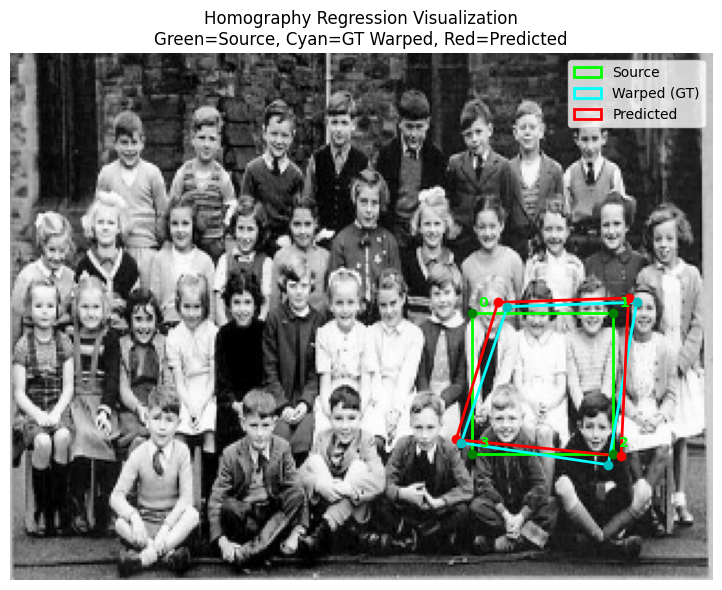

Ground Truth Offsets:
 [[16. -3.]
 [11. -5.]
 [-2.  5.]
 [-5. -5.]]
Predicted Offsets:
 [[-11.72   4.94]
 [ -7.26   6.99]
 [ -3.84  -1.07]
 [  7.25   6.51]]
Mean abs error per corner: [15.018  9.378]


In [42]:
def visualize_regression_result(model, image, window_size=64, margin=16, disp_range=(-16, 16),
                                device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.eval()

    # Generate pair from your existing pipeline
    pair, offsets_gt, src_corners, warped_true = generate_pair(
        image, window_size=window_size, margin=margin, disp_range=disp_range
    )
    dst_corners_gt = src_corners + offsets_gt  # ground-truth displaced corners

    # Prepare tensor
    pair_tensor = torch.from_numpy(pair).permute(2, 0, 1).unsqueeze(0).float().to(device)

    # Predict offsets
    with torch.no_grad():
        pred_offsets = model(pair_tensor).cpu().numpy().reshape(4, 2)

    dst_corners_pred = src_corners - pred_offsets  # predicted displaced corners

    # --- Visualization ---
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image, cmap='gray')

    # Plot polygons: source, GT, predicted
    ax.add_patch(plt.Polygon(src_corners, fill=False, edgecolor='lime', lw=2, label='Source'))
    ax.add_patch(plt.Polygon(dst_corners_gt, fill=False, edgecolor='cyan', lw=2, label='Warped (GT)'))
    ax.add_patch(plt.Polygon(dst_corners_pred, fill=False, edgecolor='red', lw=2, label='Predicted'))

    # Draw corner points and labels
    for i, (x, y) in enumerate(src_corners):
        ax.plot(x, y, 'go', markersize=6)
        ax.text(x + 3, y - 3, str(i), color='lime', fontsize=10, weight='bold')

    for (x, y) in dst_corners_pred:
        ax.plot(x, y, 'ro', markersize=6)

    for (x, y) in dst_corners_gt:
        ax.plot(x, y, 'co', markersize=6)

    ax.legend()
    ax.set_title("Homography Regression Visualization\nGreen=Source, Cyan=GT Warped, Red=Predicted")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Optional: print numeric details
    print("Ground Truth Offsets:\n", np.round(offsets_gt, 2))
    print("Predicted Offsets:\n", np.round(pred_offsets, 2))
    print("Mean abs error per corner:", np.mean(np.abs(pred_offsets - offsets_gt), axis=0).round(3))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyRegressor().to(device)
# state = torch.load("checkpoints_homography_regressor_oneImage/checkpoint_epoch_50000.pth")["model_state_dict"]
state = torch.load("checkpoints_homography_regressor_oneImage/h_regressor_ep50000_I1.pth")
model.load_state_dict(state)
model.eval()

img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
visualize_regression_result(model, img)



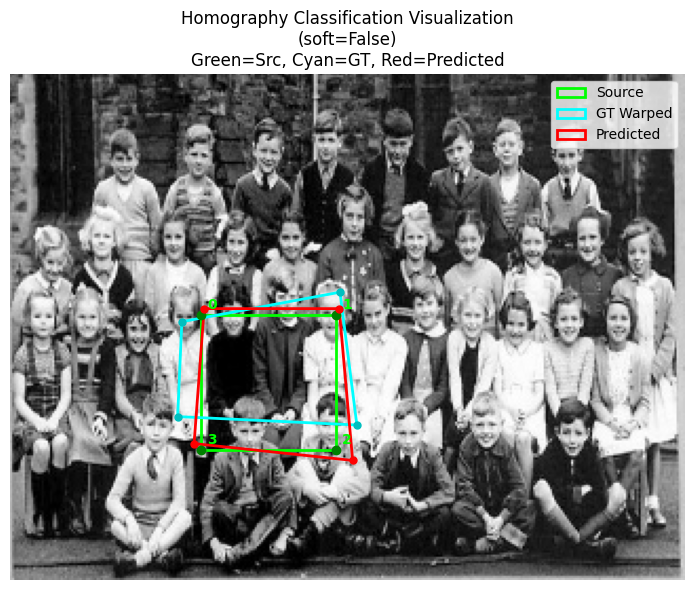

Ground Truth Offsets:
 [[ -9.   3.]
 [  2. -11.]
 [ 10. -12.]
 [-11. -16.]]
Predicted Offsets:
 [[ 1.6 -3.2]
 [ 1.6 -3.2]
 [ 8.   4.8]
 [-3.2 -3.2]]
Mean Abs Error per corner [px]: [ 5.2 10.9]
Overall Mean Abs Error: 8.050 px


np.float32(8.05)

In [37]:
def visualize_classification_result(
        model,
        image,
        window_size=64,
        margin=16,
        disp_range=(-16, 16),
        soft_decode=True,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    model.eval()

    # === Generate a random training-like pair ===
    pair, offsets_gt, src_corners, warped_true = generate_pair(
        image, window_size=window_size, margin=margin, disp_range=disp_range
    )
    dst_corners_gt = src_corners + offsets_gt  # true warped corners

    # === Prepare tensor ===
    pair_tensor = torch.from_numpy(pair).permute(2, 0, 1).unsqueeze(0).float().to(device)

    # === Forward pass ===
    with torch.no_grad():
        preds = model(pair_tensor)  # (1, 21, 8) logits
        pred_offsets = classes_to_offsets(preds, disp_range, soft=soft_decode).cpu().numpy().reshape(4, 2)

    dst_corners_pred = src_corners + pred_offsets  # predicted warped corners

    # === Visualization ===
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image, cmap='gray')

    # Draw polygons
    ax.add_patch(plt.Polygon(src_corners, fill=False, edgecolor='lime', lw=2, label='Source'))
    ax.add_patch(plt.Polygon(dst_corners_gt, fill=False, edgecolor='cyan', lw=2, label='GT Warped'))
    ax.add_patch(plt.Polygon(dst_corners_pred, fill=False, edgecolor='red', lw=2, label='Predicted'))

    # Draw corner markers
    for i, (x, y) in enumerate(src_corners):
        ax.plot(x, y, 'go', markersize=6)
        ax.text(x + 3, y - 3, str(i), color='lime', fontsize=10, weight='bold')

    for (x, y) in dst_corners_gt:
        ax.plot(x, y, 'co', markersize=5)

    for (x, y) in dst_corners_pred:
        ax.plot(x, y, 'ro', markersize=5)

    ax.legend()
    ax.set_title(f"Homography Classification Visualization\n(soft={soft_decode})\nGreen=Src, Cyan=GT, Red=Predicted")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

    # === Numeric comparison ===
    print("Ground Truth Offsets:\n", np.round(offsets_gt, 2))
    print("Predicted Offsets:\n", np.round(pred_offsets, 2))
    print("Mean Abs Error per corner [px]:", np.mean(np.abs(pred_offsets - offsets_gt), axis=0).round(3))

    mean_abs_error = np.mean(np.abs(pred_offsets - offsets_gt))
    print(f"Overall Mean Abs Error: {mean_abs_error:.3f} px")

    return mean_abs_error


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = HomographyClassifier(num_classes=21, class_dim=8).to(device)
# state = torch.load("checkpoints_homography_clasify_oneImage/h_clasify_ep50000_I1.pth")
# model.load_state_dict(state)
# model.eval()
#
# img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
# visualize_classification_result(model, img, soft_decode=False)